In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, optimizers, models
import tensorflow as tf

from utils import plot_confusion_matrix
import common

In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
data_all = pd.read_csv('fer2013/fer2013.csv')
data = data_all[data_all['emotion'] != 1]
label_binarizer = LabelBinarizer().fit(data['emotion'])

In [4]:
def preprocess(data, usage='Training'):
    ''' Returns train or test dataset '''
    groups = data.groupby('Usage')
    df_subset = groups.get_group(usage)
    
    imread = lambda x: np.fromstring(x, np.uint8, sep=' ')
    images = np.array([imread(x).reshape(*common.IM_SIZE,1)
                       for x in df_subset['pixels']])
    images = images / float(images.max())
    
    y_bin = label_binarizer.transform(df_subset['emotion'])
    return images, y_bin
    
data_train = preprocess(data, 'Training')
data_test = preprocess(data, 'PrivateTest')

In [5]:
im_size = common.IM_SIZE

model = tf.keras.Sequential([
    layers.Conv2D(64, kernel_size=3, padding='same', input_shape=(48, 48, 1), activation='relu'),
    layers.Conv2D(32, kernel_size=3, padding='same', input_shape=(48, 48, 1), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(32, kernel_size=2, padding='same', input_shape=(*im_size, 1), activation='relu'),
    layers.Conv2D(32, kernel_size=2, padding='same', input_shape=(*im_size, 1), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(common.LABELS), activation='softmax')])

model.compile(optimizer=optimizers.Adam(9e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
history = model.fit(data_train[0], data_train[1], epochs=15, batch_size=64, validation_data=data_test)

Train on 28273 samples, validate on 3534 samples
Epoch 1/15
28273/28273 [==============================] - 8s 290us/step - loss: 1.7291 - acc: 0.2725 - val_loss: 1.6496 - val_acc: 0.3523
Epoch 2/15
28273/28273 [==============================] - 7s 242us/step - loss: 1.5786 - acc: 0.3733 - val_loss: 1.5011 - val_acc: 0.4128
Epoch 3/15
28273/28273 [==============================] - 7s 241us/step - loss: 1.4914 - acc: 0.4175 - val_loss: 1.4422 - val_acc: 0.4298
Epoch 4/15
28273/28273 [==============================] - 7s 242us/step - loss: 1.4408 - acc: 0.4380 - val_loss: 1.4253 - val_acc: 0.4332
Epoch 5/15
28273/28273 [==============================] - 7s 241us/step - loss: 1.3994 - acc: 0.4543 - val_loss: 1.3917 - val_acc: 0.4559
Epoch 6/15
28273/28273 [==============================] - 7s 241us/step - loss: 1.3633 - acc: 0.4666 - val_loss: 1.3477 - val_acc: 0.4714
Epoch 7/15
28273/28273 [==============================] - 7s 240us/step - loss: 1.3323 - acc: 0.4811 - val_loss: 1.3298 - v

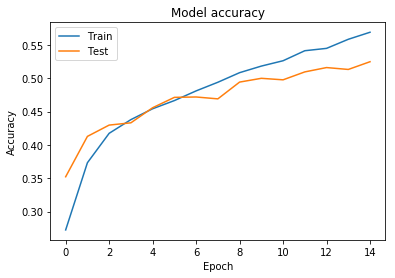

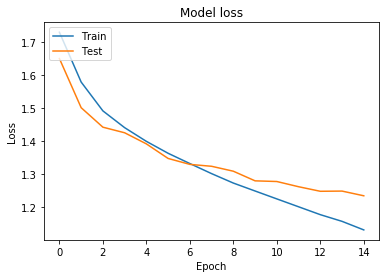

In [7]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [8]:
test_loss, test_acc = model.evaluate(*data_test)
print('Test accuracy:', test_acc)

3534/3534 [==============================] - 0s 119us/step - loss: 1.2349 - acc: 0.5249
Test accuracy: 0.524901


In [9]:
y_hat = model.predict(data_test[0]).argmax(axis=1)
conf_matrix = confusion_matrix(data_test[1].argmax(axis=1), y_hat)

Confusion matrix, without normalization
[[189  53  65  85  15  84]
 [ 74 138  66 114  56  80]
 [ 43  25 699  66  12  34]
 [ 72  60  88 228  11 135]
 [ 15  45  49  20 257  30]
 [ 48  33  98  90  13 344]]


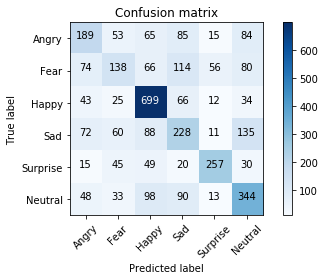

In [10]:
plot_confusion_matrix(conf_matrix, common.LABELS, normalize=0)

In [11]:
model.save(common.MODELS_PATH + 'model.h5')